In [18]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time

In [19]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

def train(net, train_iter, test_iter, trainer, num_epochs, loss_data, accuracy_data, is_inseption = False):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            if is_inseption:
                for val in net(X):
                    y_hat = val
                    break
            else:
                y_hat = net(X)
            l= loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        net.train()
        accuracy_data.append(test_acc)
        loss_data.append(train_l_sum / n)

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [21]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST ('.', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST ('.', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

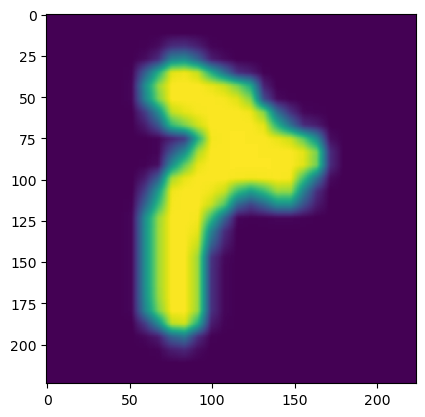

In [22]:
plt.imshow(train_dataset[0][0][0].numpy().reshape(224, 224));

In [23]:
print(train_dataset.classes)
print(len(train_dataset.classes), " classes")

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
47  classes


In [24]:
classes = train_dataset.classes
labels = train_dataset.targets
len_dataset = len(train_dataset)
for i in range(len(classes)):
    percent = 100 * torch.eq(labels, i).sum() / len_dataset
    print(f"{percent} of {classes[i]} in dataset")


2.127659559249878 of 0 in dataset
2.127659559249878 of 1 in dataset
2.127659559249878 of 2 in dataset
2.127659559249878 of 3 in dataset
2.127659559249878 of 4 in dataset
2.127659559249878 of 5 in dataset
2.127659559249878 of 6 in dataset
2.127659559249878 of 7 in dataset
2.127659559249878 of 8 in dataset
2.127659559249878 of 9 in dataset
2.127659559249878 of A in dataset
2.127659559249878 of B in dataset
2.127659559249878 of C in dataset
2.127659559249878 of D in dataset
2.127659559249878 of E in dataset
2.127659559249878 of F in dataset
2.127659559249878 of G in dataset
2.127659559249878 of H in dataset
2.127659559249878 of I in dataset
2.127659559249878 of J in dataset
2.127659559249878 of K in dataset
2.127659559249878 of L in dataset
2.127659559249878 of M in dataset
2.127659559249878 of N in dataset
2.127659559249878 of O in dataset
2.127659559249878 of P in dataset
2.127659559249878 of Q in dataset
2.127659559249878 of R in dataset
2.127659559249878 of S in dataset
2.127659559249

All classes balanced

In [25]:
def plotModelResult(loss_values, accuracy_values, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f"Results of model {model_name}")
    fig.tight_layout ()
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Accuracy, %')
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')
    x1 = range(len(loss_values))
    x2 = range(len(accuracy_values))
    ax1.plot(x1, loss_values)
    ax2.plot(x2, accuracy_values)


# Resnet 18

In [26]:
model_resnet18 = tv.models.resnet18(pretrained=False)
for param in model_resnet18.parameters():
    param.requires_grad = False

In [27]:
model_resnet18.fc

Linear(in_features=512, out_features=1000, bias=True)

In [28]:
model_resnet18.fc = nn.Linear(in_features=512, out_features=47)

In [29]:
print("Params to learn:")
params_to_update = []
for name, param in model_resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
trainer_resnet18 = torch.optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 fc.weight
	 fc.bias


In [30]:
model_resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
resnet18_loss = []
resnet18_accuracy = []

In [35]:
train(model_resnet18, train_iter, test_iter, trainer_resnet18, 10, resnet18_loss, resnet18_accuracy)

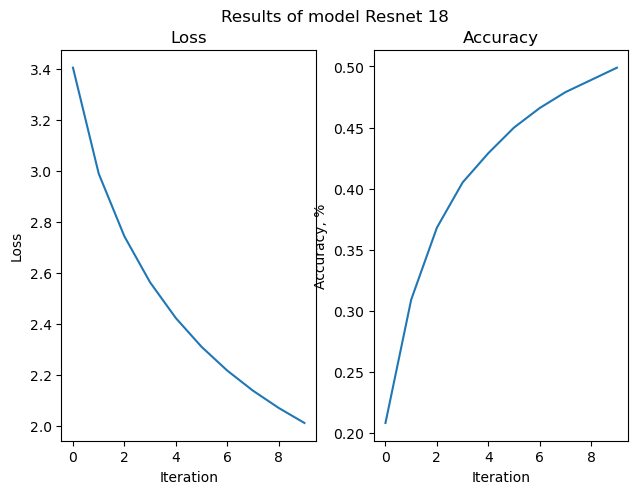

In [37]:
plotModelResult(resnet18_loss, resnet18_accuracy, "Resnet 18")

# VGG 16

In [38]:
model_vgg16 = tv.models.vgg16(pretrained=False)
for param in model_vgg16.parameters():
    param.requires_grad = False
    

In [39]:
model_vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [40]:
model_vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=47)

In [41]:
model_vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=47, bias=True)
)

In [42]:
params_to_update = []
for name, param in model_vgg16.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
trainer_vgg16 = torch.optim.Adam(params_to_update, lr=0.001)

	 classifier.6.weight
	 classifier.6.bias


In [43]:
model_vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:

from torchsummary import summary

summary(model_vgg16, input_size=(3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [45]:
vgg16_loss = []
vgg16_accuracy = []


In [ ]:
train(model_vgg16, train_iter, test_iter, trainer_vgg16, 10, vgg16_loss, vgg16_accuracy)

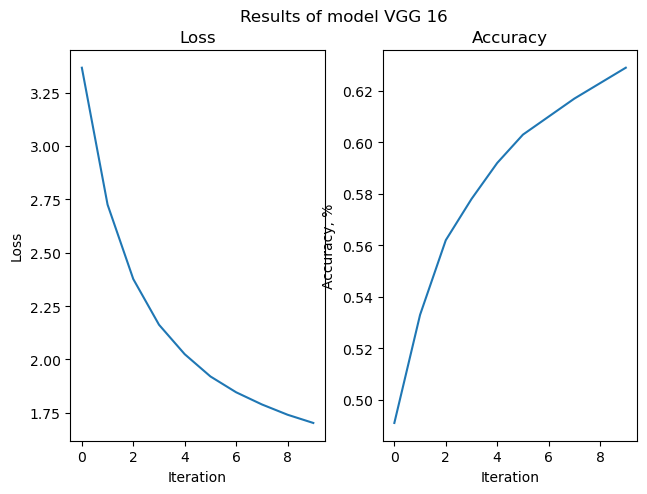

In [46]:
plotModelResult(vgg16_loss, vgg16_accuracy, "VGG 16")

# Inception v3

In [47]:
model_inception_v3 = tv.models.inception_v3(pretrained=False)
for param in model_inception_v3.parameters():
    param.requires_grad = False

C:\Users\nik\anaconda3\envs\DL\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [48]:
#inception v3 expects 299x299 images
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST ('.', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST ('.', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [49]:
model_inception_v3.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [50]:
model_inception_v3.fc = nn.Linear(in_features=2048, out_features=47)
model_inception_v3.fc

Linear(in_features=2048, out_features=47, bias=True)

In [51]:
print("Params to learn:")
params_to_update = []
for name, param in model_inception_v3.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
    
trainer_inception_v3 = torch.optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 fc.weight
	 fc.bias


In [52]:
from torchsummary import summary
model_inception_v3.to(device)
summary(model_inception_v3, input_size=(3,299,299), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [53]:
inseption_loss = []
inseption_accuracy = []


In [ ]:
train(model_inception_v3, train_iter, test_iter, trainer_inception_v3, 10, inseption_loss, inseption_accuracy, True)

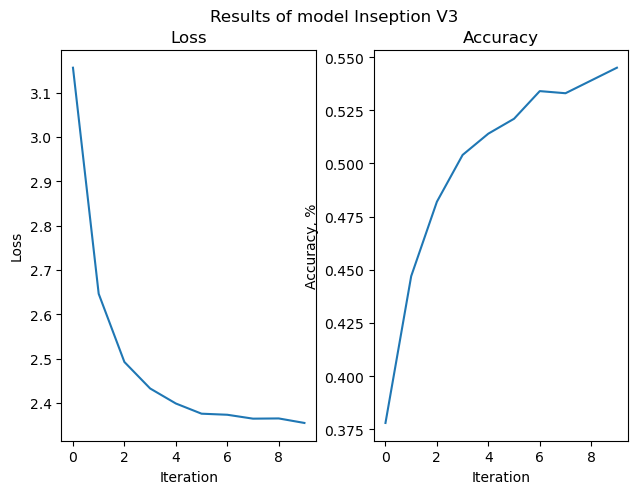

In [54]:
plotModelResult(inseption_loss, inseption_accuracy, "Inseption V3")

# DenseNet 161

In [55]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST ('.', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST ('.', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [56]:
model_densenet161 = tv.models.densenet.densenet161(pretrained=False)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = nn.Linear(in_features=2208, out_features=47)
params_to_update = []
for name, param in model_densenet161.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
trainer_densenet161 = torch.optim.Adam(params_to_update, lr=0.001)
model_densenet161.to(device)

	 classifier.weight
	 classifier.bias


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [57]:
densenet161_loss = []
densenet161_accuracy = []


In [ ]:
train(model_densenet161, train_iter, test_iter, trainer_densenet161, 10, densenet161_loss, densenet161_accuracy)

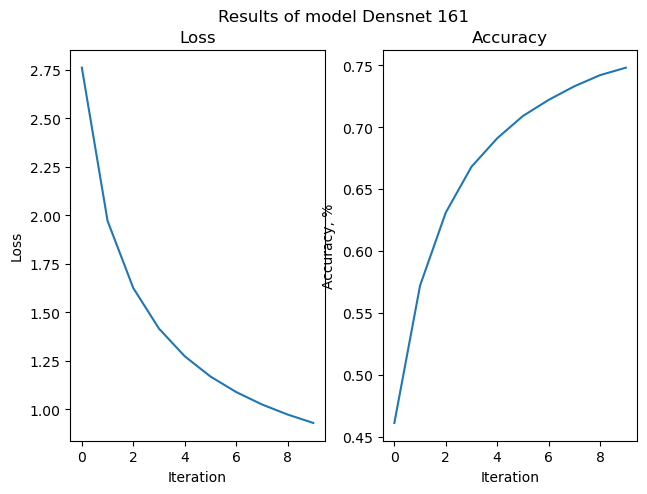

In [58]:
plotModelResult(densenet161_loss, densenet161_accuracy, "Densnet 161")

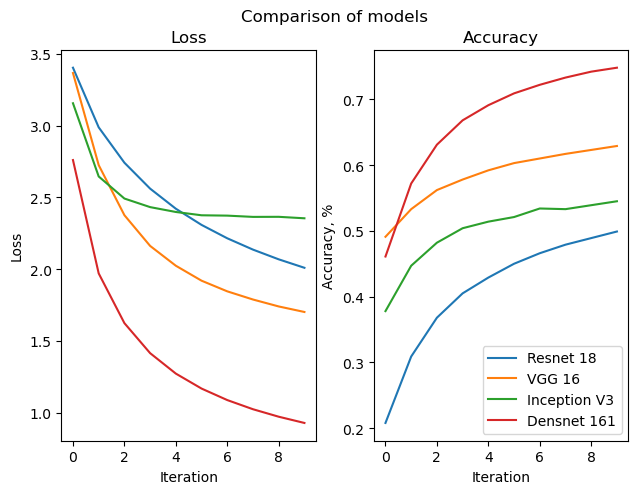

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Comparison of models")
fig.tight_layout()
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy, %')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
x = range(10)
#resnet
ax1.plot(x, resnet18_loss, label = 'Resnet 18' )
ax2.plot(x, resnet18_accuracy, label = 'Resnet 18')
#vgg 16
ax1.plot(x, vgg16_loss, label = 'VGG 16')
ax2.plot(x, vgg16_accuracy, label = 'VGG 16')
#inception v3
ax1.plot(x, inseption_loss , label = 'Inception V3')
ax2.plot(x, inseption_accuracy , label = 'Inception V3')
#densnet 161
ax1.plot(x, densenet161_loss , label = 'Densent 161')
ax2.plot(x, densenet161_accuracy , label = 'Densnet 161')
plt.legend()

In [63]:
import pandas as pd
# Создайте словарь с данными
data = {
    'Resnet Loss': resnet18_loss,
    'VGG 16 Loss': vgg16_loss,
    'Inception V3 Loss' : inseption_loss,
    'Densnet 161 Loss' : densenet161_loss

}

# Преобразуйте словарь в DataFrame
df = pd.DataFrame(data)
df.head()

,Resnet Loss,VGG 16 Loss,Inception V3 Loss,Densnet 161 Loss
0,3.4037,3.3667,3.1561,2.7605
1,2.9884,2.7253,2.6462,1.9710
2,2.7420,2.3765,2.4924,1.6246
3,2.5615,2.1625,2.4327,1.4155
4,2.4215,2.0244,2.3988,1.2731


Densnet показала наилучший результат на 10 эпохах обучения, однако при этом обучалась она дольше всего.  
Худший результат у модели Resnet, при этом обучалась она быстрее всего